 # Сборный проект 

***Описание проекта***

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

##  Изучение общей информации

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
from scipy import stats as st

In [2]:
games = pd.read_csv('games.csv')
games.head()

***Описание данных:***


* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.


In [3]:
games.info()

In [4]:
games.describe().T

### Вывод: 
На первый взгляд были замечены некоторые недочеты в данных, которые нужно исправить, а именно:
* привести к нижнему регистру названия столбцов;
* привести некоторые типы столбцов к нужному типу данных;
* обработать пропуски там, где это необходимо.

##  Предподготовка данных:

###  Приведем названия столбцов к нижнему регистру:

In [5]:
games.columns = games.columns.str.lower()

In [6]:
games

###  Обработка пропусков

Посмотрим сколько пропусков в процентном соотношении с общим количеством данных. 

In [7]:
games.isna().mean() * 100

Пропусков в колонках с Названием игры, Жанром и Годом выпуска немного, но заменять эти значения медианным нецелесообразно, т.к данные не взаимосвязаны. 

In [8]:
games['year_of_release'] = games['year_of_release'].fillna('0') #заполняю пропуски "0", т.к не знаю как привести к 
#целочисленному типу данных с пропусками

В колонках *Оценки критиков и пользователей* и *Рейтинг организации* пропусков 40%+. 

Отсутсвие оценок критиков можно объяснить тем, что конкретные игры не были достаточно популярны.   

Возможно отсутсвие оценок от игроков можно объяснить подобным образом, т.е средняя оценка считается если отзывов допустим не менее 1000.  

In [9]:
games['user_score'].sort_values().unique()

In [10]:
games['critic_score'].sort_values().unique()

Используя уникальные значения вижу, что в колонке с пользователями рейтинг на 0 я заменить не могу, поэтому для удобства заполню "-1". 

Также в колонке с оценкой пользователя есть значения "tbd", из-за которых колонка имеет не числовой тип. 


In [11]:
games.loc[(games.user_score == 'tbd'), 'user_score'] = '-1'

Пропущенные значения в *Рейтинге* объясняются тем, что не в каждой стране этот рейтинг является обязательным и создатель может не отправлять игру в ассоциацию для оценки. 

In [12]:
games['rating'] = games['rating'].fillna('no_rating') #заменяю пропуски для диаграммы шага 4.3

### Преобразуем данные в нужные типы

In [13]:
games['year_of_release'] = games['year_of_release'].astype('int')
games['user_score'] = games['user_score'].astype('float')

In [14]:
games

### Добавим толбец с суммарной продажей по миру

In [15]:
games['world_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Посмотрим на итоговые типы данных:

In [16]:
games.info()

In [17]:
games.duplicated().sum()

### Вывод: 
Данные готовы для дальнейшего анализа

## Исследовательский анализ данных

### Количество игр в разные годы

In [18]:
games_of_year = games.pivot_table(index='year_of_release', values='name', aggfunc='count')

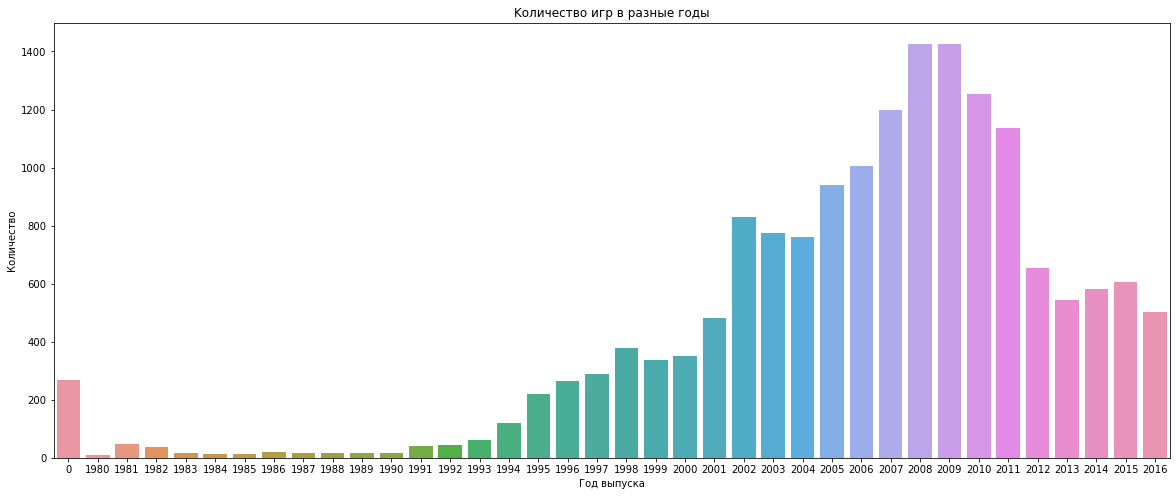

In [19]:
plt.figure(figsize=(20,8))
sns.barplot(x=games_of_year.index, y="name", data=games_of_year)
plt.title('Kоличествo игр в разные годы')
plt.xlabel('Год выпуска')
plt.ylabel('Количество')
plt.show()

#### Вывод:
Пик популярности по количеству видеоигр пришелся на 2002-2011 годы.

### Продажи по платформам

In [20]:
top_sales = games.pivot_table(index='platform',  values='world_sales', aggfunc='sum').nlargest(5, 'world_sales')
top_sales

In [21]:
top_platforms = games.query('platform == ["PS2", "DS", "PS3", "Wii", "X360" ]')

In [22]:
sales_top_platforms = top_platforms.pivot_table(index='year_of_release', columns='platform', values='world_sales', aggfunc='sum')
sales_top_platforms = sales_top_platforms.fillna(0) #заменила "0" чтобы графики выглядели более понятными

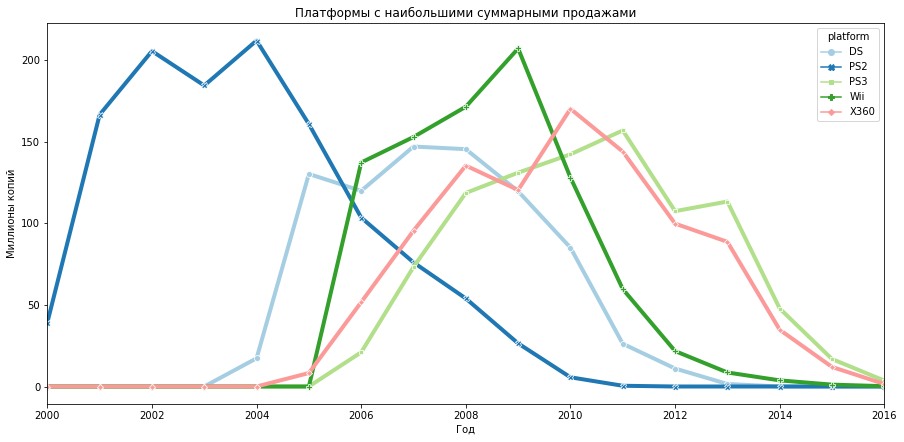

In [23]:
plt.figure(figsize=(15,7))
palette = sns.color_palette("Paired", 5)
sns.lineplot(data=sales_top_platforms, linewidth = 4, markers=True, dashes=False, palette=palette)
plt.xlim(2000, 2016)
plt.title('Платформы с наибольшими суммарными продажами')
plt.xlabel('Год')
plt.ylabel('Миллионы копий')
plt.show()

#### Вывод: 
На графике видно, что платформы "живут" примерно 10 лет, следовательно чтобы строить прогноз на 2017 год, брать данные до 2007 года не имеет смысла. 

### Возьмем данные за актуальный период:

Проделаем то же самое для актуального периода, т.е. выберем 5 самых популярных платформ по продажам и посмотрим на график.

In [24]:
actual_games = games.query('year_of_release >= 2008')

In [25]:
actual_platforms = actual_games.groupby('platform')['world_sales'].sum()
actual_platforms.nlargest(5, keep='first')

In [26]:
actual_platforms1 = actual_games.query('platform == ["PS4", "DS", "PS3", "Wii", "X360"]')
sales_actual_platforms = actual_platforms1.pivot_table(index='year_of_release', columns='platform', values='world_sales', aggfunc='sum')
sales_actual_platforms = sales_actual_platforms.fillna(0)

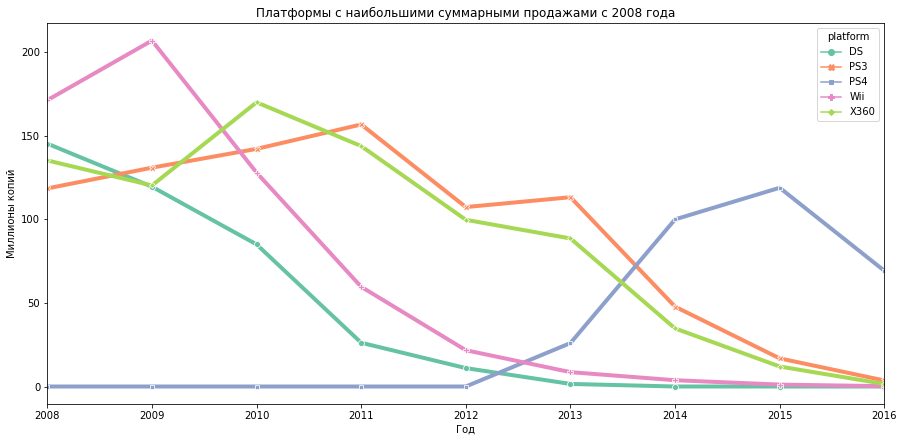

In [27]:
plt.figure(figsize=(15,7))
palette1 = sns.color_palette("Set2", 5)
sns.lineplot(data=sales_actual_platforms, linewidth = 4, markers=True, dashes=False, palette=palette1)
plt.xlim(2008, 2016)
plt.title('Платформы с наибольшими суммарными продажами c 2008 года')
plt.xlabel('Год')
plt.ylabel('Миллионы копий')
plt.show()

Все платформы кроме PS4 увядающие. Исключим их из выборки, потому что мы могли упустить платформы, которые только набирают популярность.

In [28]:
actual_games = games.query('year_of_release >= 2014') #сузим круг для набирающих популярность платформ до 2014 года
actual_platforms.nlargest(10, keep='first')

Выберем из списка платформы с наибольшими продажами, исключая неактуальные вышерассмотренные. 

In [29]:
actual_platforms2 = actual_games.query('platform == ["PS4", "3DS", "XOne", "PC", "PSP"]')
sales_actual_platforms = actual_platforms2.pivot_table(index='year_of_release', columns='platform', values='world_sales', aggfunc='sum')
sales_actual_platforms = sales_actual_platforms.fillna(0)

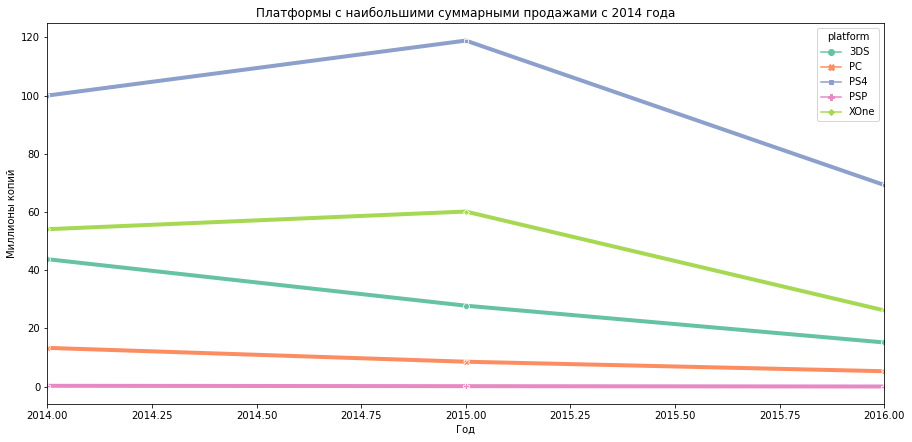

In [30]:
plt.figure(figsize=(15,7))
palette1 = sns.color_palette("Set2", 5)
sns.lineplot(data=sales_actual_platforms, linewidth = 4, markers=True, dashes=False, palette=palette1)
plt.xlim(2014, 2016)
plt.title('Платформы с наибольшими суммарными продажами c 2014 года')
plt.xlabel('Год')
plt.ylabel('Миллионы копий')
plt.show()

#### Вывод:
На этом графике очевидно, что лидируют в порядке убыли продаж такие платформы как PS4, XOne и 3DS.

### «Ящик с усами» по глобальным продажам игр

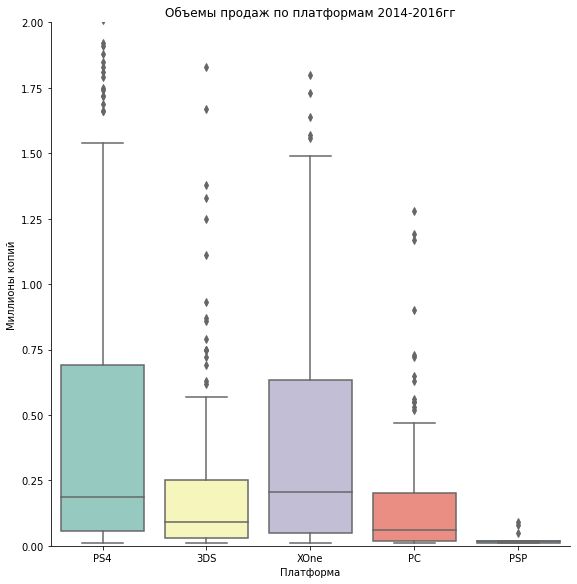

In [31]:
sns.catplot(x="platform", 
            y='world_sales', 
            kind="box", 
            data=actual_platforms2, 
            orient='v',
            palette="Set3",
            height=8)
plt.title('Объемы продаж по платформам 2014-2016гг')
plt.xlabel('Платформа')
plt.ylabel('Миллионы копий')
plt.ylim(0, 2)
plt.show()

#### Вывод:
Видим, что на отдельных проектах, которые находятся в данном случае в выбросах количество скачиваний превышает 1.5 миллиона, что делает все платформы успешными в теории для продвижения, кроме PSP и РС.

### Влияние отзывов пользователей и критиков внутри одной платформы на продажи

Рассмотрим на примере платформы PS4.

In [32]:
ps4 = actual_platforms2.query('platform == "PS4"')
ps4 = ps4[ps4['user_score'] != -1] 

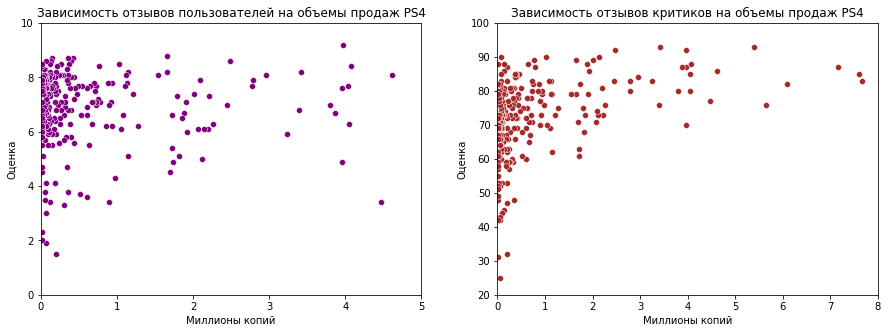

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
sns.scatterplot(data=ps4, 
            y='user_score', 
            x='world_sales',
            color='purple',
            ax=axes[0])
axes[0].set_title('Зависимость отзывов пользователей на объемы продаж PS4')
axes[0].set_xlabel('Миллионы копий')
axes[0].set_ylabel('Оценка')
axes[0].set_xlim(0, 5)
axes[0].set_ylim(0, 10)
sns.scatterplot(data=ps4, 
            x='world_sales', 
            y='critic_score',
            color='brown',
            ax=axes[1])
axes[1].set_title('Зависимость отзывов критиков на объемы продаж PS4')
axes[1].set_xlabel('Миллионы копий')
axes[1].set_ylabel('Оценка')
axes[1].set_xlim(0, 8)
axes[1].set_ylim(20, 100)

plt.show()
print('Корреляция между оценками пользователей и продажами:', ps4['user_score'].corr(ps4['world_sales']))
print('Корреляция между оценками критиков и продажами:', ps4['critic_score'].corr(ps4['world_sales']))


Зависимость между оценками пользователей и объемом продаж отсутствует. Зависимость между оценками критиков и общими продажами присутствует, но она слабо выражена. 

#### Вывод:
Проецируя полученные результаты на другие платформы, можно так же сказать, что зависимости между отзывами пользователей и количеством продаж нет, а зависимость между отзывами критиков и общими продажами крайне мала.

### Распределение игр по жанрам

In [34]:
genres = games.groupby('genre')['world_sales'].median()

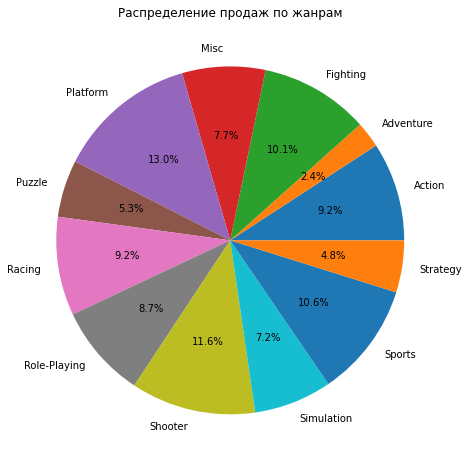

In [35]:
genres.plot(
    kind='pie', title = "Распределение продаж по жанрам", figsize=(8, 8), autopct='%1.1f%%'
).set(ylabel='')
plt.show()

Игры в жанре 'Platform' и 'Shooter' лидируют по продажам. Самыми непопулярным жанром является 'Adventure'.

**Теперь посмотрим на распредение в актуальном для нас периоде времени**

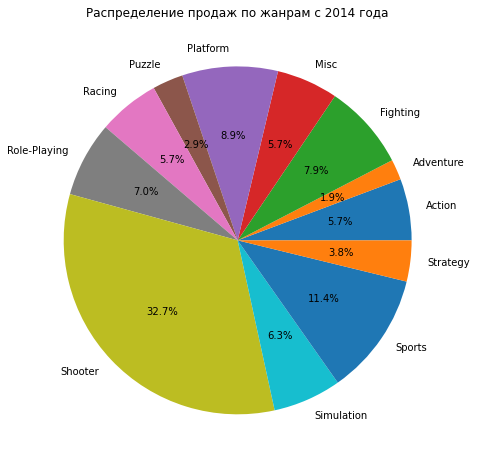

In [36]:
top_genres = actual_games.groupby('genre')['world_sales'].median()
top_genres.plot(
    kind='pie', title = "Распределение продаж по жанрам с 2014 года", 
    figsize=(8, 8), autopct='%1.1f%%'
).set(ylabel='');

#### Вывод:
Набрал обороты 'Shooter' и стал лидирующим жанром. Несколько улучшилось положение 'Sports'. А вот категория 'Platform' немного сдает позиции. 

### Вывод:


Учитывая проведенный выше анализ, на данном этапе можно сказать что наиболее перспективными платформами для продвижения на 2017 год будут PS4 и XOne. 

Наиболее актуальными и "беспроигрышными" жанрами будут 'Shooter', 'Sports' и 'Platform'.

## Портрет каждого региона

Будем работать далее с актуальными данными, начиная с 2014 года, т.к. итоговая разница присутствует, а цель нашего проекта все-таки прогноз, а не просто статистика.

### Самые популярные платформы (топ-5) по регионам

Чтобы взять в столбчатый график именно 5 топ регионов мне пришлось создать свой мини-датафрейм, т.к иначе у меня для региона Японии выпадали популярные жанры.

In [37]:
top_platforms_on_eu = actual_games.pivot_table(
    index='platform', values= 'eu_sales', aggfunc='sum'
).nlargest(5, 'eu_sales')
print(top_platforms_on_eu)

top_platforms_on_jp = actual_games.pivot_table(
index='platform', values='jp_sales', aggfunc='sum'
).nlargest(5, 'jp_sales')
print(top_platforms_on_jp)

top_platforms_on_na = actual_games.pivot_table(
index='platform', values='na_sales', aggfunc='sum'
).nlargest(5, 'na_sales')
print(top_platforms_on_na)

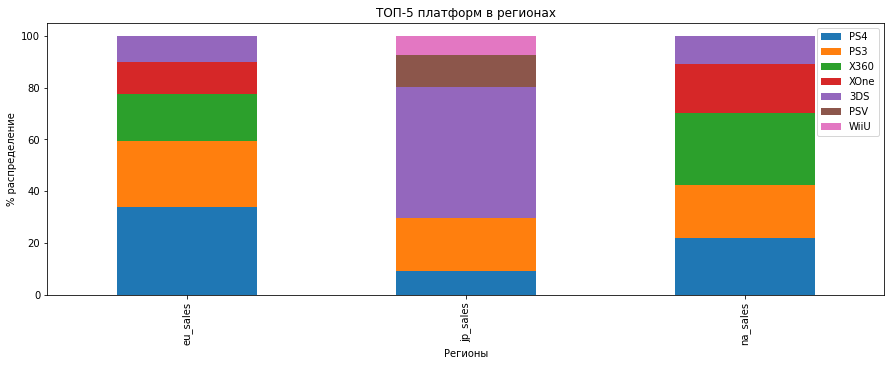

In [38]:
top_platforms_on_regions = pd.DataFrame({
    'eu_sales': [141.09, 106.86, 74.52, 51.59, 42.64, 0, 0],
    'jp_sales': [15.96, 35.29, 0, 0, 87.79, 21.04, 13.01],
    'na_sales': [108.74, 103.38, 140.05, 93.12, 55.31, 0, 0]
}, index=['PS4', 'PS3', 'X360', 'XOne', '3DS', 'PSV', 'WiiU']
)
top_platforms_on_regions = top_platforms_on_regions.transpose()
top_platforms_on_regions = top_platforms_on_regions.apply(lambda x: x*100/sum(x), axis=1)
top_platforms_on_regions.plot(kind="bar", stacked=True, figsize=(15,5))
plt.title("ТОП-5 платформ в регионах")
plt.xlabel("Регионы")
plt.ylabel("% распределение")

#### Вывод:
Первое что бросается в глаза - это то, что в регионах Японии совершенно не популярны XBox. Но, в каждом из представленных регионов относительно популярны Sony PlayStation. Т.к платформу PS3 мы причислили к затухающей, то PS4 и 3DS являются наиболее перспективными, если рассматривать мировой рынок. 

### Самые популярные жанры (топ-5)

In [39]:
top_genres_on_na = actual_games.pivot_table(
index='genre', values='na_sales', aggfunc='median').nlargest(5, 'na_sales')
print(top_genres_on_na)


top_genres_on_eu = actual_games.pivot_table(
index='genre', values='eu_sales', aggfunc='median'
).nlargest(5, 'eu_sales')
print(top_genres_on_eu)


top_genres_on_jp = actual_games.pivot_table(
index='genre', values='jp_sales', aggfunc='median'
).nlargest(5, 'jp_sales')
print(top_genres_on_jp)

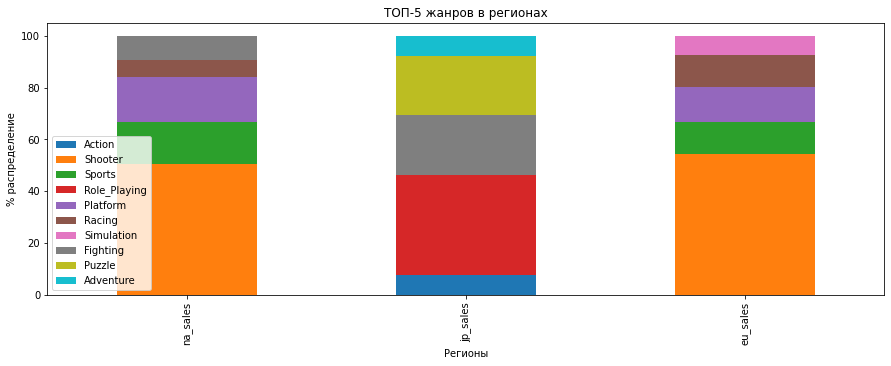

In [40]:
top_genres_on_regions = pd.DataFrame({
    'na_sales': [0, 0.22, 0.07, 0, 0.075, 0.03, 0, 0.04, 0, 0],
    'jp_sales': [0.01, 0, 0, 0.05, 0, 0, 0, 0.03, 0.03, 0.01],
    'eu_sales': [0, 0.22, 0.05, 0, 0.055, 0.05, 0.03, 0, 0, 0]
}, index=['Action', 'Shooter', 'Sports', 'Role_Playing', 'Platform', 'Racing', 'Simulation', 'Fighting', 'Puzzle', 'Adventure']
)
top_genres_on_regions = top_genres_on_regions.transpose()
top_genres_on_regions = top_genres_on_regions.apply(lambda x: x*100/sum(x), axis=1)
top_genres_on_regions.plot(kind="bar", stacked=True, figsize=(15,5))
plt.title("ТОП-5 жанров в регионах")
plt.xlabel("Регионы")
plt.ylabel("% распределение")

#### Вывод:
Shooter и Sports больше подходят для продаж в регионе Европы и Северной Америки, в то время как в регоине Японии популярными жанрами являются Role-Playing и Fighting. Т.о. выбирая жанр нужно отталкиваться от выбранного региона/ов.

### Влияние рейтинга ESRB на продажи в отдельном регионе

In [41]:
rating_on_regions = actual_games.pivot_table(
index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
rating_on_regions

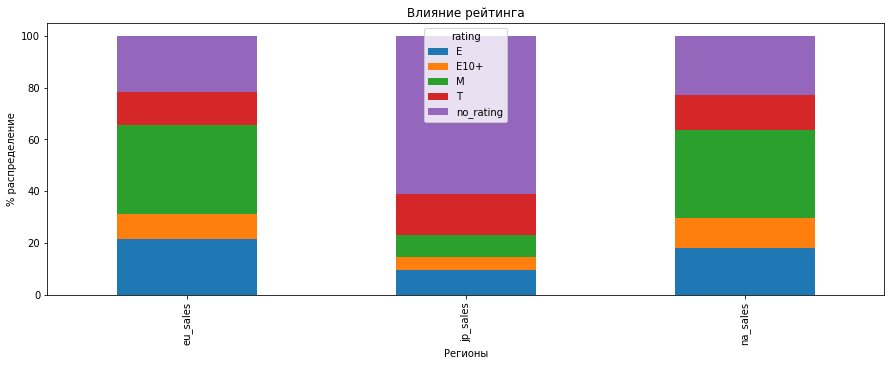

In [42]:
rating_on_regions = rating_on_regions.transpose()
rating_on_regions = rating_on_regions.apply(lambda x: x*100/sum(x), axis=1)
rating_on_regions.plot(kind="bar", stacked=True, figsize=(15,5))
plt.title("Влияние рейтинга")
plt.xlabel("Регионы")
plt.ylabel("% распределение")

#### Вывод:
Наиболее популярными играми являются игры категории М - для взрослых, старше 17 лет. Игры подходящие для любого возраста - Е,тоже пользуются популярностью. 
Примечательно, что в регионе Японии в большинстве случаев не характерно наличие рейтинга для игр. 

### Вывод:
Исходя из полученных расчетов можно выделить наиболее перспективные платформы, такие как *PS4*, *3DS* и *XOne*. 

Самыми многообещающими жанрами являются *Shooter*, *Role_Playing* и *Sports*. 

А игры для возрастной категории *М*, *Е*  имеют наиболее высокие продажи. Так же как и игры без рейтинга.

## Проверка гипотез


### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

* H0 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
* H1 - Средние пользовательские рейтинги платформ Xbox One и PC отличаются.

In [43]:
xone = actual_games.query('platform == "XOne"')['user_score']
pc = actual_games.query('platform == "PC"')['user_score']

In [44]:
alpha = 0.05 
results = st.ttest_ind(
xone,
pc,  nan_policy='omit')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Полученное значение p-value говорит о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковы.

### Средние пользовательские рейтинги жанров Action и Sports  разные

* H0: средние пользовательские рейтинги жанров Actionи Sports одинаковые.

Исходя из H0 формулируем альтернативную гипотезу. 
* H1:средние пользовательские рейтинги жанров Action и Sports различаются.

In [45]:
action = actual_games.query('genre == "Action"')['user_score']
sports = actual_games.query('genre == "Sports"')['user_score']

In [46]:
alpha = 0.05 
results = st.ttest_ind(
action,
sports, nan_policy='omit')
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Полученное значение p-value говорит о том, что средние пользовательские рейтинги жанров Action и Sports различаются.

## Общий вывод:

1. При планировании кампании на 2017-й год необходимо ориентироваться на игровую платформу PS4 если целью является мировой рынок. Для рынка Северной Америки и Европы также популярной является платформа Xbox One. Имея цель быть популрным на рынке Японии лучше выбрать плафторму 3DS. 

2. Игра должна быть в жанре Shooter, Sports или Platform. Три этих жанра дают захват наибольшей аудитории. В регионе Японии следует обратить внимание на не менее перспективный Role_Playing.

3. Продавать игры прибыльнее рейтинга M или рейтинга Е (игры без рейтинга тоже могут сюда относиться). 

